https://keras.io/examples/keras_recipes/bayesian_neural_networks/

https://keras.io/examples/generative/vae/

References:

1. Generative Deep Learning - David Foster
2. Variational Autoencoder: Intuition and Implementation - Agustinus Kristiadi
3. Deep Learning with Python - Francois Chollet

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import datasets

## Generating Dataset

System: In 2D space, a free particle (A) and a particle (B) constrained to move on a circle.

The particle A is moving with initial velocity $u$ and the angular velocity of B is $\omega$. Their masses are $m_1\;\&\;m_2$ respectively.

Let the particle A collides with particle B at $(0, r).$ The final velocity of A is $v$ and final angular velocity of B is $\omega'$.

In [3]:
def generateData(p1inx_min=-10, p1inx_max=-5, v1inx_min=0.5, v1inx_max=1, v1iny_min=-0.5, v1iny_max=0.5, omega_min=-1, omega_max=1, r=1, m1=1, m2=1, units=5, samples=1000):
  p1inx = np.random.uniform(low=p1inx_min, high=p1inx_max, size=(samples,1))
  v1inx = np.random.uniform(low=v1inx_min, high=v1inx_max, size=(samples,1))
  v1iny = np.random.uniform(low=v1iny_min, high=v1iny_max, size=(samples,1))
  #v1finx = np.random.uniform(low=v1inx_min/2, high=v1iny_max/2, size=(samples,1))
  #v1finy = np.random.uniform(low=v1iny_min/2, high=v1iny_max/2, size=(samples,1))
  omega = np.random.uniform(low=omega_min, high=omega_max, size=(samples,1))

  v1finx_threshold = np.sqrt(v1inx**2 + m2*r**2*omega**2/m1)
  v1finx = np.random.uniform(low=-v1finx_threshold/1.1, high=v1finx_threshold/1.1, size=(samples, 1))
  v1finy = v1inx

  t_collision = -p1inx/v1inx

  p1iny = r - v1iny*t_collision
  #p2inx = -r*np.cos(omega*t_collision)
  #p2iny = -r*np.sin(omega*t_collision)

  l2in = m2*omega*r**2
  l1in = m1*(p1inx*v1iny - p1iny*v1inx)
  lin = l1in + l2in

  t_pre_collision = np.linspace(start=t_collision-5, stop=t_collision, num=units, axis=1)[:,:,0]
  t_post_collision = np.linspace(start=t_collision, stop=t_collision+5, num=units, axis=1)[:,:,0]
  #step = 10/units
  #diff = np.random.uniform(low=-step/units, high=step/units, size=(samples, units))
  #t_pre_collision = t_pre_collision + diff
  #diff = np.random.uniform(low=-step/units, high=step/units, size=(samples, units))
  #t_post_collision = t_post_collision + diff
  #t_pre_collision = np.random.uniform(low=t_collision-10, high=t_collision-1, size=(samples, units))
  #t_post_collision = np.random.uniform(low=t_collision+1, high=t_collision+10, size=(samples, units))

  p1x_pre = p1inx + v1inx*t_pre_collision
  p1y_pre = p1iny + v1iny*t_pre_collision
  p2x_pre = -r*np.sin(omega*(t_pre_collision-t_collision))
  p2y_pre = r*np.cos(omega*(t_pre_collision-t_collision))
  #p2x_pre = p2inx + r*np.cos(omega*t_pre_collision)
  #p2y_pre = p2iny + r*np.sin(omega*t_pre_collision)
  #p1x_post = p1inx + v1finx*t_post_collision
  #p1y_post = p1iny + v1finy*t_post_collision
  p1x_post = v1finx*(t_post_collision-t_collision)
  p1y_post = r + v1finy*(t_post_collision-t_collision)

  #l2fin = -m2*r*v1inx
  #l1fin = lin - l2fin
  #omega_fin = l2fin/(m2*r**2)
  omega_fin = omega + (v1finx - v1inx)*m1/(m2*r)

  p2x_post = -r*np.sin(omega_fin*(t_post_collision-t_collision))
  p2y_post = r*np.cos(omega_fin*(t_post_collision-t_collision))
  #p2x_post = r*np.cos(omega_fin*(t_post_collision-t_collision))
  #p2y_post = r*(1 + np.sin(omega_fin*(t_post_collision-t_collision)))

  t_prediction = t_collision + 5
  p2x_prediction = -r*np.sin(omega_fin*(t_prediction-t_collision))
  p2y_prediction = r*np.cos(omega_fin*(t_prediction-t_collision))

  return t_pre_collision, p1x_pre, p1y_pre, p2x_pre, p2y_pre, t_collision, t_post_collision, p1x_post, p1y_post, p2x_post, p2y_post, t_prediction, p2x_prediction, p2y_prediction, lin

In [4]:
samples = int(1e1)
units=50
t_pre_collision, p1x_pre, p1y_pre, p2x_pre, p2y_pre, t_collision, t_post_collision, p1x_post, p1y_post, p2x_post, p2y_post, t_prediction, p2x_prediction, p2y_prediction, lin = generateData(units=units, samples=samples)

[]

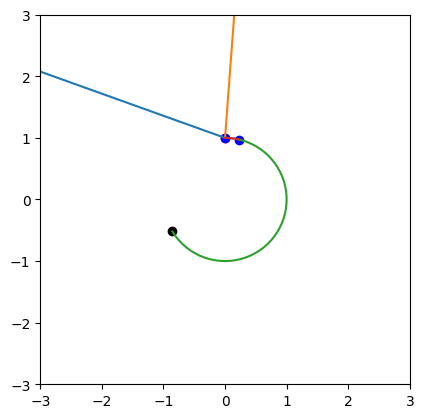

In [32]:
index1 = 2
plt.plot(p1x_pre[index1], p1y_pre[index1])
plt.plot(p1x_post[index1], p1y_post[index1])
plt.plot(p2x_pre[index1], p2y_pre[index1])
plt.plot(p2x_post[index1], p2y_post[index1])

plt.scatter(p2x_pre[index1,0], p2y_pre[index1,0], c='black')
plt.scatter(p2x_pre[index1,-1], p2y_pre[index1,-1], c='red')
plt.scatter(p2x_post[index1,[1,-1]], p2y_post[index1,[1,-1]], c='blue')
ax = plt.gca()
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')
plt.plot()

#Building Model

##$\beta$-Variational Autoencoder

In [7]:
#dfine a sampling subclass of Layer
#the Sampling layer takes two inputs: mean and log_var
#the layer samples random samples from mean and log_var assuming that the mean and log_var are from from a gaussian distribution
class Sampling(keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, inputs):
    #unpack the inputs
    z_mean, z_log_var = inputs
    batch_size = tf.shape(z_mean)[0]
    #size of the latent layer
    units = tf.shape(z_mean)[1]
    #generate random samples from a gaussian distribution of mean=0 and standard deviation=1
    epsilon = tf.random.normal(shape=(batch_size, units), mean=0, stddev=1)
    #shift and scale epsilon
    return z_mean + tf.math.exp(z_log_var/2)*epsilon

In [8]:
#create a subclass VAE of Model
#the model takes encoder and decoder models and joins them to build beta-VAE
#the model defines a training method to train the beta-VAE model so constructed
"""Variables in the class object:

   encoder               --   encoder model to produce mean and log_var as output from the input
   decoder               --   decoder model to produce the output
   reconstruction_loss   --   total loss for the output accuracy of the decoder - sum over total outputs and average over samples
   kl_loss               --   total loss for the kl-metric - sum over output units of latent layer and average over samples
   total_loss            --   reconstruction_loss + kl_loss
   beta_rec              --   parameter to control the relative significance of reconstruction loss
   beta_kl               --   parameter to control the relative significance of kl-divergence loss
"""

class VAE(Model):
  #
  def __init__(self, encoder, decoder, beta_rec=500., beta_kl=1., target_var=0.01, variational=True, **kwargs):
    super().__init__(**kwargs)

    self.encoder = encoder
    self.decoder = decoder

    self.variational = variational
    self.beta_rec = beta_rec
    if self.variational:
      self.beta_kl = beta_kl
      self.target_var = target_var

    #define the losses
    #Mean stores the mean value of the argument passed to it and a name for the mean value
    self.total_reconstruction_loss = keras.metrics.Mean(name='reconstruction_loss')
    if self.variational:
      self.total_kl_loss = keras.metrics.Mean(name='kl_loss')
      self.total_loss = keras.metrics.Mean(name='total_loss')

  @property
  #return the losses to be printed during training
  def metrics(self):
    if self.variational:
      return [self.total_loss, self.total_reconstruction_loss, self.total_kl_loss]
    else:
      return [self.total_reconstruction_loss]

  #feeds an output of encoder and question to the decoder and returns the outputs of encoder and decoder
  #encoder input and a question is passed as input
  def call(self, inputs):
    observation = list(inputs[0])
    question = list(inputs[1])

    if self.variational:
      z_mean, z_log_var, z = self.encoder(observation)
      predictions = self.decoder([z] + question)
      return z_mean, z_log_var, z, predictions
    else:
      z = self.encoder(observation)
      predictions = self.decoder([z] + question)
      return z, predictions

  #training method called when called to fit
  #the method is passed a set of observation, a question for each observation and the corresponding answers
  def train_step(self, data):
    inputs = list(data['time_series'])
    question = list(data['t_question'])
    outputs = data['answer']

    with tf.GradientTape() as tape:
      #feed-forward step
      #calls the call() method
      if self.variational:
        z_mean, z_log_var, z, predictions = self([inputs, question])
      else:
        z, predictions = self([inputs, question])
      #calculate losses for the current feed-forward step
      #outputs and predictions are one dimensional so only take mean over samples
      reconstruction_loss = self.beta_rec*tf.reduce_mean(keras.losses.mean_squared_error(outputs, predictions))
      #take sum over dimension and mean over samples
      #kl_loss = 0.5*self.beta_kl*tf.reduce_mean(tf.reduce_sum(tf.square(z_mean) + tf.exp(z_log_var) -  z_log_var, axis=1))
      if self.variational:
        kl_loss = 0.5*self.beta_kl*tf.reduce_mean(tf.reduce_sum(tf.square(z_mean)/self.target_var + tf.exp(z_log_var)/self.target_var -  z_log_var + tf.math.log(self.target_var), axis=1)-3)
      else:
        kl_loss=0
      loss = reconstruction_loss + kl_loss

      #calculates gradients w.r.t. the trainable weights of the model
      gradients = tape.gradient(loss, self.trainable_weights)
      #updates the trainable weights using the gradients calculated
      #method to update the weights is passed in call to compile function of the model as optimizer parameter
      self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

      #updates the current losses
      self.total_reconstruction_loss.update_state(reconstruction_loss)
      if self.variational:
        self.total_kl_loss.update_state(kl_loss)
        self.total_loss.update_state(loss)

      #return the losses name and the corresponding values
      return {m.name: m.result() for m in self.metrics}

##Encoder

The encoder takes as input time series of 50 positions of the pendulum.

The encoder consists of two hidden layers of different dimensions. Next, two layers for $mean$ and $\log(variance)$. Each of the two have dimension `latent_dim`, which is the dimension the latent layer. The output of the latent layer is sampled from normal distributions using the outputs of the layers `z_mean` and `z_log_var` as means and $\log(variance)$ of the gaussian distributions.

In [33]:
input_sizes = [5]*6
latent_dim = 1

#inputs = [t1_pre_collision, p1x_pre, p1y_pre, t2_pre_collision, p2x_pre, p2y_pre]
inputs = [Input(shape=(input_sizes[i],), name='input'+str(i)+'_layer') for i in range(6)]
encoder_input = keras.layers.Concatenate()(inputs)
encoder_l1 = Dense(150, activation='tanh', name='encoder_layer1')(encoder_input)
encoder_l2 = Dense(100, activation='tanh', name='encoder_layer2')(encoder_l1)
z_mean = Dense(latent_dim, name='z_mean')(encoder_l2)
z_log_var = Dense(latent_dim, name='z_log_var')(encoder_l2)

#generate random samples from gaussian distribution with mean = z_mean and log(variance) = z_log_var
z = Sampling(name='sampling_layer')([z_mean, z_log_var])
#z = Dense(1, name='encoder_out')(encoder_l2)

encoder = Model(inputs=inputs, outputs=[z_mean, z_log_var, z], name='encoder')
#encoder = Model(inputs=inputs, outputs=z, name='encoder')

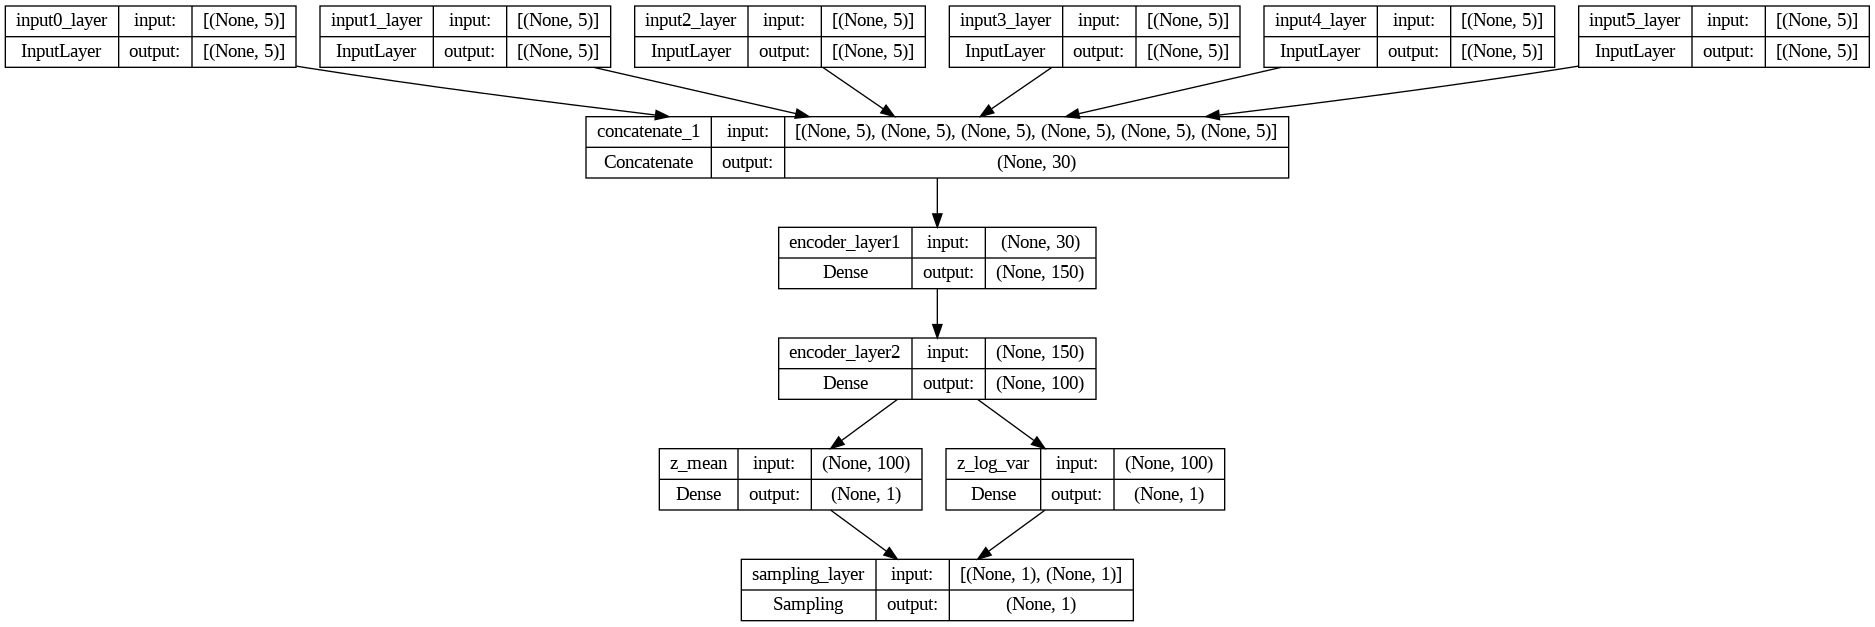

In [10]:
#the graph of the encoder model
#each node is a layer
#the description of the layers consists of the layer name, the input and the output dimension of the layer
keras.utils.plot_model(encoder, show_shapes=True)

##Decoder

The decoder consists of hidden layers and an output layer. The input to the decoder is the gaussian sample output of the encoder and a question through question layer. The output is the answer to the question given the representation of the observation as the output of the encoder.

In [34]:
question_sizes = [1, 5, 5, 5]

#question to be feeded to the decoder
#questions = [t_prediction, t_post_collision, p1x_post, p1y_post]
questions = [Input(shape=(question_sizes[i],), name='question'+str(i)+'_layer') for i in range(4)]

In [35]:
output_size = 2

latent_layer = Input(shape=(latent_dim,), name='latent_layer')
decoder_question_input = keras.layers.Concatenate()(questions)
decoder_input = keras.layers.Concatenate()([latent_layer, decoder_question_input])

decoder_l1 = Dense(100, activation='tanh', name='decoder_layer1')(decoder_input)
decoder_l2 = Dense(150, activation='tanh', name='decoder_layer2')(decoder_l1)
#output = [p2x_post, p2y_post]
decoder_out = Dense(output_size, activation='tanh', name='decoder_layer_out')(decoder_l2)

decoder = Model(inputs=[latent_layer] + questions, outputs=decoder_out, name='decoder')

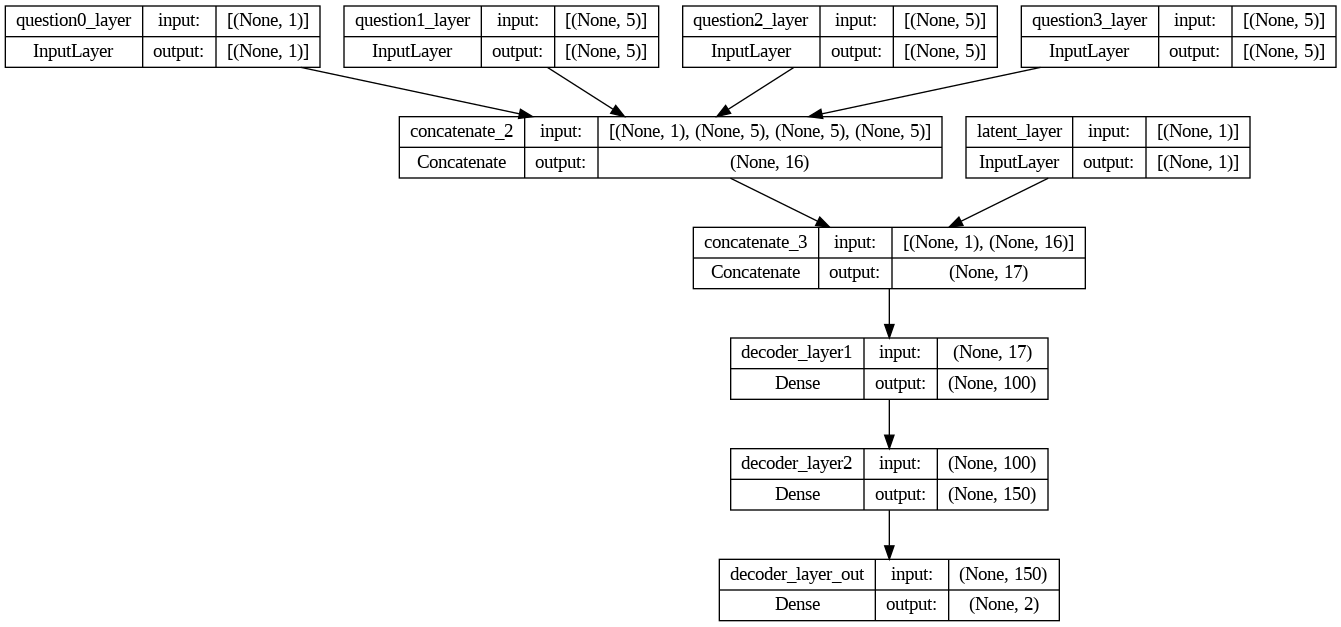

In [13]:
keras.utils.plot_model(decoder, show_shapes=True)

##Train Model

Each sample in the training consists of a time series of 50 positions of pendulum, the prediction time as a question and the corresponding answer to the question, which is the position o fthe pendulum.

A large sample is generated by varying the frequency and the damping parameter fo the pendulum. The parameters are randomly chosen in the specified range.

In [14]:
train_samples = int(5e5)
t_pre_collision_train, p1x_pre_train, p1y_pre_train, p2x_pre_train, p2y_pre_train, t_collision_train, t_post_collision_train, p1x_post_train, p1y_post_train, p2x_post_train, p2y_post_train, t_prediction_train, p2x_prediction_train, p2y_prediction_train, lin_train = generateData(omega_min=0.1, omega_max=1.5, samples=train_samples)
print(t_pre_collision_train.shape)
print(p1x_pre_train.shape)
print(p2x_pre_train.shape)

(500000, 5)
(500000, 5)
(500000, 5)


In [36]:
collision = VAE(encoder, decoder, beta_rec=2.0, beta_kl=0, target_var=0.01, variational=True)

In [37]:
learning_rate = 1e-3
batch_size=500
epochs=50

collision.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
collision.fit({'time_series': [t_pre_collision_train, p1x_pre_train, p1y_pre_train, t_pre_collision_train, p2x_pre_train, p2y_pre_train], 't_question': [t_prediction_train, t_post_collision_train, p1x_post_train, p1y_post_train], 'answer': np.column_stack((p2x_prediction_train, p2y_prediction_train))}, batch_size=batch_size, epochs=epochs)

Epoch 1/50
1000/1000 [==============================] - 10s 8ms/step - total_loss: 0.3425 - reconstruction_loss: 0.3425 - kl_loss: 0.0000e+00
Epoch 2/50
1000/1000 [==============================] - 7s 7ms/step - total_loss: 0.0493 - reconstruction_loss: 0.0493 - kl_loss: 0.0000e+00
Epoch 3/50
1000/1000 [==============================] - 8s 8ms/step - total_loss: 0.0340 - reconstruction_loss: 0.0340 - kl_loss: 0.0000e+00
Epoch 4/50
1000/1000 [==============================] - 8s 8ms/step - total_loss: 0.0277 - reconstruction_loss: 0.0277 - kl_loss: 0.0000e+00
Epoch 5/50
1000/1000 [==============================] - 7s 7ms/step - total_loss: 0.0195 - reconstruction_loss: 0.0195 - kl_loss: 0.0000e+00
Epoch 6/50
1000/1000 [==============================] - 9s 9ms/step - total_loss: 0.0155 - reconstruction_loss: 0.0155 - kl_loss: 0.0000e+00
Epoch 7/50
1000/1000 [==============================] - 9s 9ms/step - total_loss: 0.0117 - reconstruction_loss: 0.0117 - kl_loss: 0.0000e+00
Epoch 8/50
1

In [44]:
learning_rate = 5e-4
batch_size=500
epochs=50

collision.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
collision.fit({'time_series': [t_pre_collision_train, p1x_pre_train, p1y_pre_train, t_pre_collision_train, p2x_pre_train, p2y_pre_train], 't_question': [t_prediction_train, t_post_collision_train, p1x_post_train, p1y_post_train], 'answer': np.column_stack((p2x_prediction_train, p2y_prediction_train))}, batch_size=batch_size, epochs=epochs)

Epoch 1/50
1000/1000 [==============================] - 11s 10ms/step - total_loss: 2.6819e-04 - reconstruction_loss: 2.6819e-04 - kl_loss: 0.0000e+00
Epoch 2/50
1000/1000 [==============================] - 9s 9ms/step - total_loss: 1.0955e-04 - reconstruction_loss: 1.0955e-04 - kl_loss: 0.0000e+00
Epoch 3/50
1000/1000 [==============================] - 8s 8ms/step - total_loss: 1.4156e-04 - reconstruction_loss: 1.4156e-04 - kl_loss: 0.0000e+00
Epoch 4/50
1000/1000 [==============================] - 8s 8ms/step - total_loss: 1.3383e-04 - reconstruction_loss: 1.3383e-04 - kl_loss: 0.0000e+00
Epoch 5/50
1000/1000 [==============================] - 7s 7ms/step - total_loss: 1.3264e-04 - reconstruction_loss: 1.3264e-04 - kl_loss: 0.0000e+00
Epoch 6/50
1000/1000 [==============================] - 8s 8ms/step - total_loss: 1.3080e-04 - reconstruction_loss: 1.3080e-04 - kl_loss: 0.0000e+00
Epoch 7/50
1000/1000 [==============================] - 7s 7ms/step - total_loss: 1.2384e-04 - reconstru

In [56]:
learning_rate = 1e-4
batch_size=500
epochs=50

collision.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
collision.fit({'time_series': [t_pre_collision_train, p1x_pre_train, p1y_pre_train, t_pre_collision_train, p2x_pre_train, p2y_pre_train], 't_question': [t_prediction_train, t_post_collision_train, p1x_post_train, p1y_post_train], 'answer': np.column_stack((p2x_prediction_train, p2y_prediction_train))}, batch_size=batch_size, epochs=epochs)

Epoch 1/50
1000/1000 [==============================] - 9s 8ms/step - total_loss: 3.5832e-05 - reconstruction_loss: 3.5832e-05 - kl_loss: 0.0000e+00
Epoch 2/50
1000/1000 [==============================] - 7s 7ms/step - total_loss: 3.2975e-05 - reconstruction_loss: 3.2975e-05 - kl_loss: 0.0000e+00
Epoch 3/50
1000/1000 [==============================] - 8s 8ms/step - total_loss: 3.2771e-05 - reconstruction_loss: 3.2771e-05 - kl_loss: 0.0000e+00
Epoch 4/50
1000/1000 [==============================] - 6s 6ms/step - total_loss: 3.2428e-05 - reconstruction_loss: 3.2428e-05 - kl_loss: 0.0000e+00
Epoch 5/50
1000/1000 [==============================] - 8s 8ms/step - total_loss: 3.1883e-05 - reconstruction_loss: 3.1883e-05 - kl_loss: 0.0000e+00
Epoch 6/50
1000/1000 [==============================] - 7s 7ms/step - total_loss: 3.1735e-05 - reconstruction_loss: 3.1735e-05 - kl_loss: 0.0000e+00
Epoch 7/50
1000/1000 [==============================] - 8s 8ms/step - total_loss: 3.1522e-05 - reconstruct

##Validating the model

The test sample is similarly generated. The answer to the question is predicted by the model for each sample.

In [18]:
test_samples = int(5e4)
t_test_pre_collision, p1x_test_pre, p1y_test_pre, p2x_test_pre, p2y_test_pre, t_test_collision, t_test_post_collision, p1x_test_post, p1y_test_post, p2x_test_post, p2y_test_post, t_test_prediction, p2x_test_prediction, p2y_test_prediction, lin_test = generateData(omega_min=0.1, omega_max=1.5, units=5, samples=test_samples)

[]

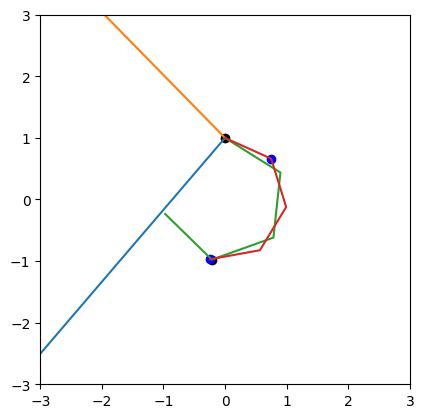

In [ ]:
index1 = 10
plt.plot(p1x_test_pre[index1], p1y_test_pre[index1])
plt.plot(p1x_test_post[index1], p1y_test_post[index1])
plt.plot(p2x_test_pre[index1], p2y_test_pre[index1])
plt.plot(p2x_test_post[index1], p2y_test_post[index1])

plt.scatter(p2x_test_pre[index1,[1,-1]], p2y_test_pre[index1,[1,-1]], c='black')
plt.scatter(p2x_test_post[index1,[1,-1]], p2y_test_post[index1,[1,-1]], c='blue')
ax = plt.gca()
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')
plt.plot()

In [57]:
obs = [t_test_pre_collision, p1x_test_pre, p1y_test_pre, t_test_pre_collision, p2x_test_pre, p2y_test_pre]
ques = [t_test_prediction, t_test_post_collision, p1x_test_post, p1y_test_post]
z_mu, z_logvar, z, x_test_prediction = collision.predict([obs, ques])
#z = encoder.predict(obs)
#z, x_test_prediction = collision.predict([obs, ques])

1563/1563 [==============================] - 3s 2ms/step


In [58]:
x_true = np.column_stack((p2x_test_prediction, p2y_test_prediction))
error_squared = (x_test_prediction - x_true)**2

In [59]:
mse = error_squared.sum(axis=1).mean()
mse

1.8686428989309642e-05

[]

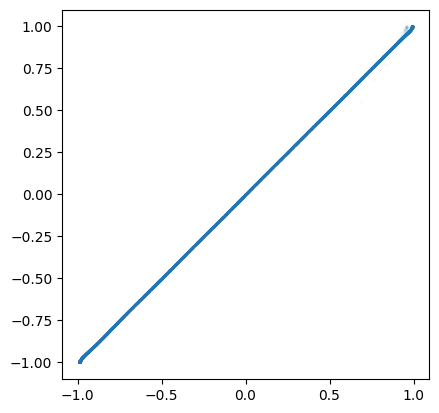

In [60]:
#plt.scatter(lin_test, z, s=0.5)
plt.scatter(x_test_prediction[:,0], x_true[:,0], s=0.001)
ax = plt.gca()
#ax.set_ylim(-2,2)
ax.set_aspect('equal')
plt.plot()

[]

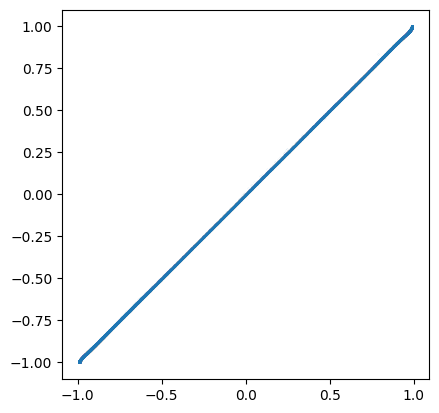

In [61]:
#plt.scatter(lin_test, z, s=0.5)
plt.scatter(x_test_prediction[:,1], x_true[:,1], s=0.001)
ax = plt.gca()
#ax.set_ylim(-2,2)
ax.set_aspect('equal')
plt.plot()

[]

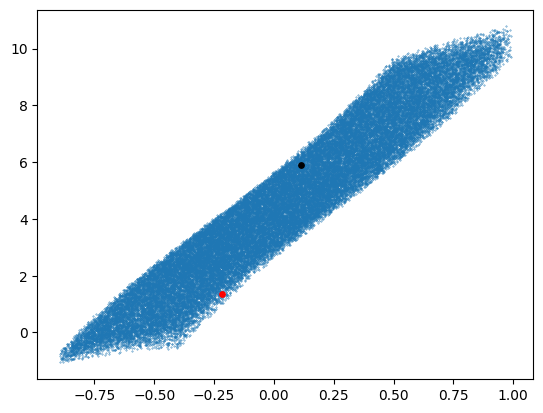

In [71]:
plt.scatter(lin_test, z_layer, s=0.1)
plt.scatter(lin_test[1], z[1], s=15, c='black')
plt.scatter(lin_test[3], z[3], s=15, c='red')
#plt.scatter(x_test_prediction[:,0], x_true[:,0], s=0.5)
ax = plt.gca()
#ax.set_ylim(-2,2)
#ax.set_aspect('equal')
plt.plot()

[]

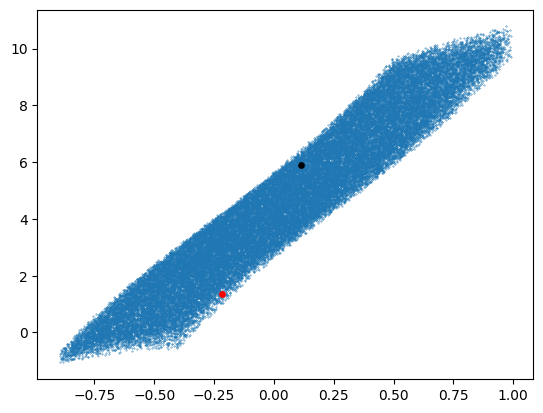

In [72]:
plt.scatter(lin_test, z_mu_layer, s=0.1)
plt.scatter(lin_test[1], z[1], s=15, c='black')
plt.scatter(lin_test[3], z[3], s=15, c='red')
#plt.scatter(x_test_prediction[:,0], x_true[:,0], s=0.5)
ax = plt.gca()
#ax.set_ylim(-2,2)
#ax.set_aspect('equal')
plt.plot()

In [70]:
z_mu_layer, z_logvar_layer, z_layer = encoder.predict(obs)

1563/1563 [==============================] - 3s 2ms/step


In [ ]:
x_test_ans = x_test_ans.reshape(-1,1)

In [ ]:
def MSE(x_pred, x_ans, batch_size=10):
  mse = 0
  start = 0
  end = batch_size
  num_batches = int(x_pred.shape[0]/batch_size)

  for batch in range(num_batches):
    mse = (np.square(x_pred[start:end] - x_ans[start:end])).sum()
    start += batch_size
    end += batch_size

  return mse.mean()

In [ ]:
mse = MSE(x_test_prediction, x_test_ans, batch_size=1000)

ValueError: operands could not be broadcast together with shapes (1000,1) (200,1) 

In [ ]:
mu = x_test_ans.mean()
mu

0.004429453935575459

In [ ]:
np.sqrt(mse)

In [ ]:
t0, t1 = 0, 10
b0, b1 = 0.1, 1
k0, k1 = 5, 10
N_grid = 100

B = np.linspace(b0, b1, N_grid)
K = np.linspace(k0, k1, N_grid)

b_grid, k_grid = np.meshgrid(B, K)
layer_z = [np.zeros(N_grid**2).reshape(b_grid.shape)]*3
layer_mean = [np.zeros(N_grid**2).reshape(b_grid.shape)]*3
layer_logvar = [np.zeros(N_grid**2).reshape(b_grid.shape)]*3

for i in range(N_grid):
  for j in range(N_grid):
    b, k = b_grid[i,j], k_grid[i,j]
    t, xt_series = generateTrajectory(t0=t0, t1=t1, b=b, k=k, samples=50)
    mean, log_var, z = encoder(xt_series)
    z = z.numpy().flatten()
    layer_z[0][i,j] = z[0]
    layer_z[1][i,j] = z[1]
    layer_z[2][i,j] = z[2]

    z = mean.numpy().flatten()
    layer_mean[0][i,j] = z[0]
    layer_mean[1][i,j] = z[1]
    layer_mean[2][i,j] = z[2]

    z = log_var.numpy().flatten()
    layer_logvar[0][i,j] = z[0]
    layer_logvar[1][i,j] = z[1]
    layer_logvar[2][i,j] = z[2]

In [ ]:
t, xt_series = generateTrajectory(t0=t0, t1=t1, b=0.1, k=5, samples=50)
mean, log_var, zout = encoder(xt_series)

In [ ]:
print(mean)
print(log_var)
print(zout)

tf.Tensor([[-0.28245395 -0.3753568   0.39236444]], shape=(1, 3), dtype=float32)
tf.Tensor([[ 0.01279005  0.04746556 -0.1887543 ]], shape=(1, 3), dtype=float32)
tf.Tensor([[ 0.01408318 -0.30462527 -0.50230145]], shape=(1, 3), dtype=float32)


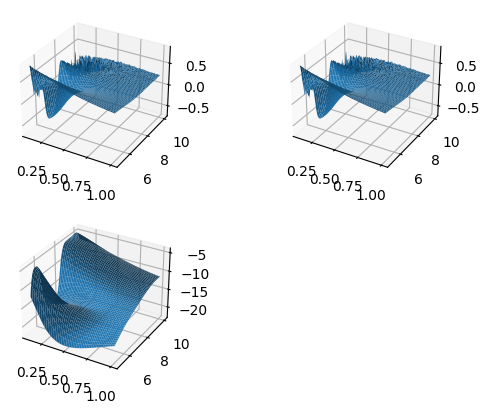

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': '3d'})
plt.xlabel('b')
plt.ylabel('k')
#ax.set_xlim(0.6, 1)
#ax.set_ylim(5, 10)
#for a1 in ax:
 # for a2 in a1:
  #  z=a2.set_zlim3d(-1, 1)

ax[0,0].plot_surface(b_grid, k_grid, layer_z[0])
ax[0,1].plot_surface(b_grid, k_grid, layer_z[1])
ax[1,0].plot_surface(b_grid, k_grid, layer_logvar[2])
fig.delaxes(ax[1,1])
plt.show()

Below, the model is provided a time series of position as an observation and the position of the pendulum is asked for a range of time to obtain the predicted trajectory of the pendulum.

In [ ]:
#generate observation data and test samples with a fixed value of spring constant and damping parameter
samples = 200

#observation data
t_obs, x_obs = generateTrajectory(t0=0, t1=5, b=0.5, k=5, samples=50)
#test questions as array of times and the corresponding answer as the position of the pendulum
t_ques, x_true_ans = generateTrajectory(t0=0, t1=10, b=0.5, k=5, samples=samples)

In [ ]:
z_mu = np.zeros(samples*3).reshape(samples, 3)
z_logvar = np.zeros(samples*3).reshape(samples, 3)
z = np.zeros(samples*3).reshape(samples, 3)
#array to store the predicted answers of the model
x_pred_ans = np.zeros(samples).reshape(1,samples)

#generate answer to each questions
for i in range(samples):
  z_mu[i:i+1, :], z_logvar[i:i+1, :], z[i:i+1,:], x_pred_ans[:,i:i+1] = pendulum.predict([x_obs, t_ques[:,i:i+1]], verbose=0)

In [ ]:
t_ques = t_ques.reshape(-1,1)
x_true_ans = x_true_ans.reshape(-1,1)
x_pred_ans = x_pred_ans.reshape(-1,1)

[]

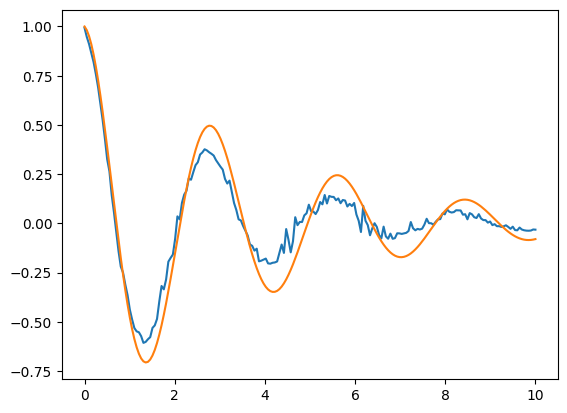

In [ ]:
plt.plot(t_ques, x_pred_ans)
plt.plot(t_ques, x_true_ans)
plt.plot()

#Denoising using Autoencoder

In [ ]:
variational_autoencoder = VAE(encoder, decoder, beta_rec=10., beta_kl=1)
variational_autoencoder.compile(optimizer='adam')
variational_autoencoder.fit(x_train_reshaped, x_train_reshaped, batch_size=128, epochs=10)

In [ ]:
latent_z_mu, latent_z_logvar, x_prediction_reshaped = variational_autoencoder.predict(x_test_reshaped)

Let us introduce some noise to the images and see how the autoencoder performs on the noised images.

In [ ]:
#create noises for the training and test datasets as random values
train_noise = np.random.uniform(low=-0.7, high=0.7, size=(1, x_train_reshaped.shape[1]))
test_noise = np.random.uniform(low=-0.7, high=0.7, size=(1, x_test_reshaped.shape[1]))

In [ ]:
#add the noise
x_train_noise = x_train_reshaped + train_noise
x_test_noise = x_test_reshaped + test_noise
#clip the noise in the range [0,1]
x_train_noise = np.clip(x_train_noise, a_min=0, a_max=1)
x_test_noise = np.clip(x_test_noise, a_min=0, a_max=1)

We see that the encoder is performing badly for the noised data. This is because the encoder is not trained to remove the noise. So, lets pass the encoder noised data and train it to produce denoised images.